# Import Zone

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [3]:
df = pd.read_csv('data/Aircraft_Incident_Dataset.csv')
df_types = df.dtypes
df_shape = df.shape
print(f'The size of the dataframe is {df_shape[0]} rows and {df_shape[1]} columns.')
print('\nThe columns have the following names & types: ')
print(df_types)

The size of the dataframe is 23519 rows and 23 columns.

The columns have the following names & types: 
Incident_Date           object
Aircaft_Model           object
Aircaft_Registration    object
Aircaft_Operator        object
Aircaft_Nature          object
Incident_Category       object
Incident_Cause(es)      object
Incident_Location       object
Aircaft_Damage_Type     object
Date                    object
Time                    object
Arit                    object
Aircaft_Engines         object
Onboard_Crew            object
Onboard_Passengers      object
Onboard_Total           object
Fatalities               int64
Aircaft_First_Flight    object
Aircraft_Phase          object
Departure_Airport       object
Destination_Airport     object
Ground_Casualties       object
Collision_Casualties    object
dtype: object


## Data Segmentation

Extract only the information related with Domestic Scheduled Passenger (DSP), separating the dataframe in Incidents DSP with fatalities and DSP without fatalities:

In [4]:
df_dsp_wofatalities = df[(df["Aircaft_Nature"] == "Domestic Scheduled Passenger") & (df["Fatalities"] == 0)]
df_dsp_wofatalities_shape = df_dsp_wofatalities.shape
df_dsp_wfatalities  = df[(df["Aircaft_Nature"] == "Domestic Scheduled Passenger") & (df["Fatalities"] > 0)]
df_dsp_wfatalities_shape = df_dsp_wfatalities.shape

print(f'The number of records of Domestic Scheduled Passenger with fatalities are: {df_dsp_wfatalities_shape[0]}')
print(f'The number of records of Domestic Scheduled Passenger without fatalities are: {df_dsp_wofatalities_shape[0]}')

The number of records of Domestic Scheduled Passenger with fatalities are: 1755
The number of records of Domestic Scheduled Passenger without fatalities are: 2249


# Causes

## Determine the most common reason/cause of airplane crashes and their fatality rate?

### What are the categories of cause most common in accidents with fatalities?

In [5]:
#Extract just the data related with incident cause (Column 7) when the accidents have fatalities and Separate each value by "," Character, due to each value has multiple causes, For example: Airplane - Engines, Airplane - Engines - Fire, Cargo - Overloaded
all_causes_wfatalities_separated = df_dsp_wfatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))

#Iterate each flight to get just the first word of each cause, for example : Airplane - Engines -> Airplane and eliminating the duplicates in each element.
all_causes_wfatalities_separated_unique = all_causes_wfatalities_separated.apply(lambda x: list(set([elem.split('-')[0].strip() for elem in x])))

#Transform the set in a flat list with all the causes
flat_list_all_causes_wfatalities = [word for series in all_causes_wfatalities_separated_unique for word in series]

#Count the frecuency of each cause and delete word mountain due to it is not a category and take just the top 5 values
series_all_causes_wfatalities_frecuency = pd.Series(flat_list_all_causes_wfatalities).value_counts().drop('mountain')[:5]
series_all_causes_wfatalities_frecuency



Result      1281
Info         369
Airplane     224
Weather      164
Security     137
dtype: int64

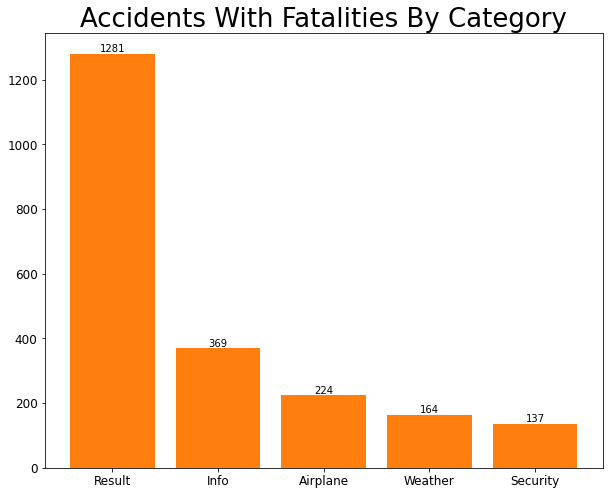

In [6]:
#Ploting zone:
fig, ax = plt.subplots()

#Defien x & y values for the plot
causes = series_all_causes_wfatalities_frecuency.index
causes_frequency = series_all_causes_wfatalities_frecuency.values

#Adding bar values
ax.bar(causes, causes_frequency)
bars = ax.bar(causes, causes_frequency)
ax.bar_label(bars)

#Adding title to th chart and font sizes
ax.set_title('Accidents With Fatalities By Category', fontsize = 26)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

#Ploting the chart
plt.show()

## What happen with these categories in accidents without fatalities?

In [7]:
#Extract just the data related with incident cause (Column 7) when the accidents have fatalities and Separate each value by "," Character, due to each value has multiple causes, For example: Airplane - Engines, Airplane - Engines - Fire, Cargo - Overloaded
all_causes_wofatalities_separated = df_dsp_wofatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))

#Iterate each flight to get just the first word of each cause, for example : Airplane - Engines -> Airplane and eliminating the duplicates in each element.
all_causes_wofatalities_separated_unique = all_causes_wofatalities_separated.apply(lambda x: list(set([elem.split('-')[0].strip() for elem in x])))

#Transform the set in a flat list with all the causes
flat_list_all_causes_wofatalities = [word for series in all_causes_wofatalities_separated_unique for word in series]

#Count the frecuency of each cause and delete word mountain due to it is not a category and take just the top 5 values
series_all_causes_wofatalities_frecuency = pd.Series(flat_list_all_causes_wofatalities).value_counts().drop('mountain')
series_all_causes_wofatalities_frecuency = series_all_causes_wofatalities_frecuency.loc[['Result', 'Info', 'Airplane', 'Weather', 'Security']]
series_all_causes_wofatalities_frecuency

Result      1756
Info         238
Airplane     321
Weather       73
Security     678
dtype: int64

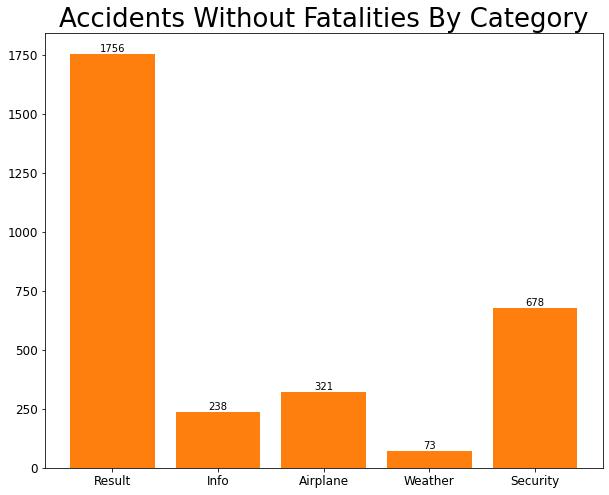

In [8]:
#Ploting zone:
fig, ax = plt.subplots()

#Defien x & y values for the plot
causes = series_all_causes_wofatalities_frecuency.index
causes_frequency = series_all_causes_wofatalities_frecuency.values

#Adding bar values
ax.bar(causes, causes_frequency)
bars = ax.bar(causes, causes_frequency)
ax.bar_label(bars)

#Adding title to th chart and font sizes
ax.set_title('Accidents Without Fatalities By Category', fontsize = 26)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

#Ploting the chart
plt.show()

## Comparison between accidents with/without fatalities

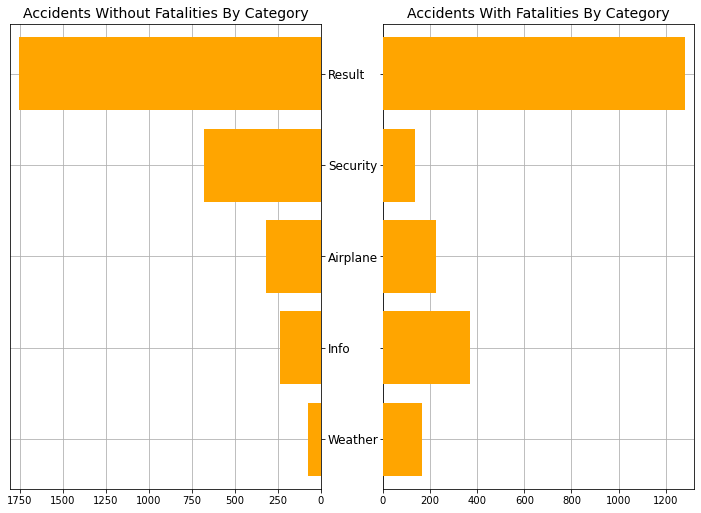

In [9]:
# Data
causes = series_all_causes_wfatalities_frecuency.index

wofatalities = series_all_causes_wofatalities_frecuency.values

wfatalities = series_all_causes_wfatalities_frecuency.values

# Sort by number of wfatalities wofatalities
idx = wofatalities.argsort()
causes, wofatalities, wfatalities = [np.take(x, idx) for x in [causes, wofatalities, wfatalities]]

y = np.arange(wfatalities.size)

# Prepare bars alignment
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].barh(y, wofatalities, align='center', color='orange', zorder=10)
ax[1].barh(y, wfatalities, align='center', color='orange', zorder=10)

ax[0].set_title('Accidents Without Fatalities By Category', fontsize = 14)
ax[1].set_title('Accidents With Fatalities By Category', fontsize = 14)
ax[0].invert_xaxis()
ax[0].set(yticks=y, yticklabels=causes)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].yaxis.tick_right()

for ax in ax.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

plt.show()

## What are the subcategories inside "Result" most common in accidents with fatalities?

In [54]:
#Get the data with fatalities
all_causes_wfatalities_separated = df_dsp_wfatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))
#Get just the accident causes that contains the word "Result"
only_result_category = all_causes_wfatalities_separated.apply(lambda lista: [item for item in lista if 'Result' in item])
#Get the subcategory inside result
sub_result_categories = only_result_category.apply(lambda x: list([elem.split('-')[1] for elem in x]))
#Transform the set in a flat list with all the causes
sub_result_categories_flat = [word for series in sub_result_categories for word in series]
#Count the frecuency of each subcategory
sub_result_categories_frecuency = pd.Series(sub_result_categories_flat).value_counts()[:5]
sub_result_categories_frecuency

 CFIT                493
 Loss of control     482
 Emergency           103
 Runway excursion     88
 Hijacking            64
dtype: int64

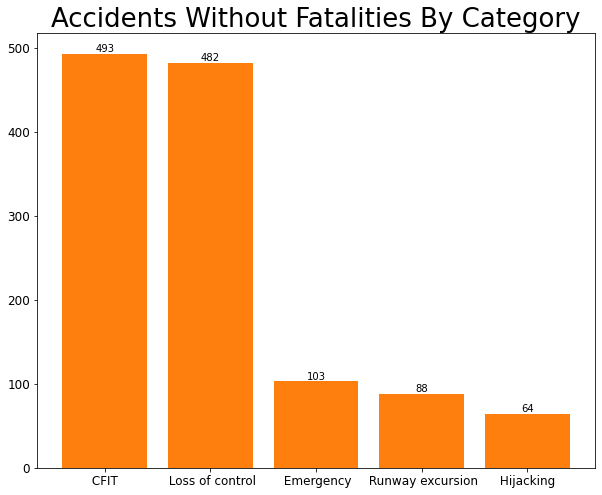

In [55]:
#Ploting zone:
fig, ax = plt.subplots()

#Defien x & y values for the plot
causes = sub_result_categories_frecuency.index
causes_frequency = sub_result_categories_frecuency.values

#Adding bar values
ax.bar(causes, causes_frequency)
bars = ax.bar(causes, causes_frequency)
ax.bar_label(bars)

#Adding title to th chart and font sizes
ax.set_title('Accidents Without Fatalities By Category', fontsize = 26)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

#Ploting the chart
plt.show()